/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` i

Episode 50	Average Reward: 44.30
Episode 100	Average Reward: 130.72

Environment solved in 144 episodes with average reward 195.24 over the last 50.00 episodes.


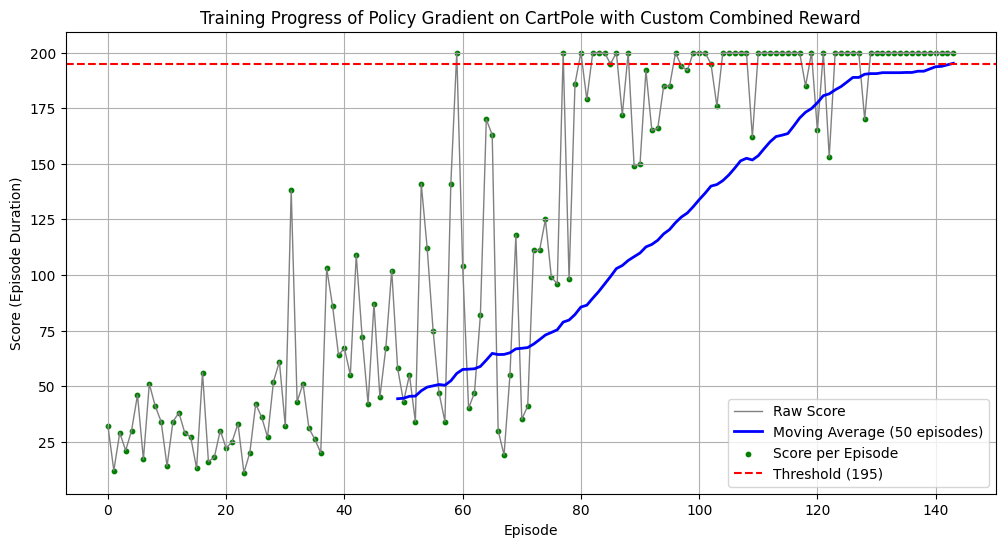

Test Scores Summary:
count    100.0
mean     200.0
std        0.0
min      200.0
25%      200.0
50%      200.0
75%      200.0
max      200.0
Name: Score, dtype: float64
Success Count (Score >= 195):
Success
True    100
Name: count, dtype: int64


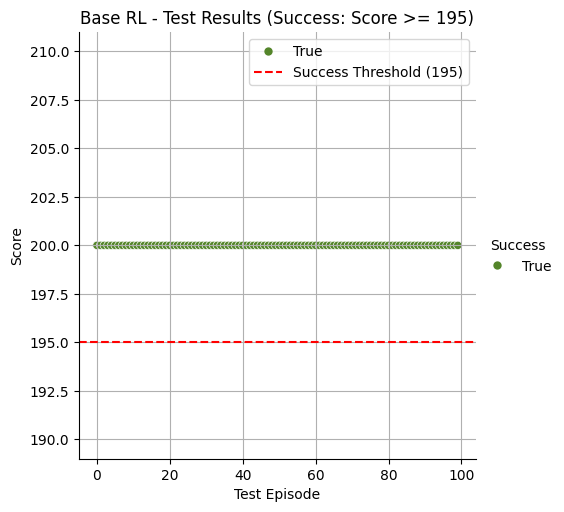

In [7]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym, random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


# Set the random seed for reproducibility
seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Create the environment
env = gym.make('CartPole-v0')
env.seed(seed)

# Get state and action dimensions
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Get thresholds from environment constraints
theta_threshold = (env.observation_space.high[2]) / 2 - 0.001  # Pole angle
x_threshold = env.observation_space.high[0]  # Cart position

# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, action_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        probs = self.softmax(x)
        return probs

# Instantiate the policy network
policy_net = PolicyNetwork(state_dim, action_dim, hidden_size=128)

# Set the optimizer
learning_rate = 0.003
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

# Training parameters
gamma = 0.95
num_episodes = 500
max_steps = 500

# For logging
episode_rewards = []

for episode in range(1, num_episodes + 1):
    env.seed(episode)
    state = env.reset()
    env.seed(episode)

    state = torch.from_numpy(state).float()
    rewards = []
    log_probs = []

    for t in range(max_steps):
        # Get action probabilities from the policy network
        probs = policy_net(state)
        # Sample an action from the probability distribution
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        log_prob = m.log_prob(action)
        # Step the environment
        next_state, _, done, _ = env.step(action.item())

        # Extract state variables
        x = abs(next_state[0])  # Cart position (absolute value)
        theta = abs(next_state[2])  # Pole angle (absolute value)

        # Compute custom rewards
        weight1=0.15
        cart = np.exp((x_threshold - x) / x_threshold) - 0.999  # Cart position reward
        angle = np.exp((theta_threshold - theta) / theta_threshold) - 0.999  # Pole angle reward
        reward = (weight1 * cart) + ((1-weight1) * angle)  # Combined reward

        next_state = torch.from_numpy(next_state).float()
        # Save reward and log probability
        rewards.append(reward)
        log_probs.append(log_prob)
        # Update state
        state = next_state
        if done:
            break

    # Compute the cumulative rewards (returns) for the episode
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    returns = torch.tensor(returns)
    # Normalize returns for better convergence
    returns = (returns - returns.mean()) / (returns.std() + 1e-9)
    # Compute policy gradient loss
    loss = []
    for log_prob, Gt in zip(log_probs, returns):
        loss.append(-log_prob * Gt)
    loss = torch.stack(loss).sum()
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Log episode reward
    episode_rewards.append(t + 1)
    # Print progress every 50 episodes
    if episode % 50 == 0:
        avg_reward = np.mean(episode_rewards[-50:])
        print(f"Episode {episode}\tAverage Reward: {avg_reward:.2f}")

    convergence_criteria = 50
    # Check for convergence
    if episode >= convergence_criteria:
        avg_reward = np.mean(episode_rewards[-convergence_criteria:])
        if avg_reward >= 195.0:
            print(f"\nEnvironment solved in {episode} episodes with average reward {avg_reward:.2f} over the last {convergence_criteria:.2f} episodes.")
            break

# Close the environment
env.close()

# Convert 'episode_rewards' to a NumPy array for easy manipulation
score_array = np.array(episode_rewards)

# Calculate a moving average with a window size of 50
window_size = 50
if len(score_array) >= window_size:
    moving_avg = np.convolve(score_array, np.ones(window_size) / window_size, mode='valid')
else:
    moving_avg = score_array  # If not enough data points, use the raw scores

# Plot the raw scores and the moving average
plt.figure(figsize=(12, 6))
plt.plot(score_array, color='gray', linewidth=1, label='Raw Score')
plt.plot(range(window_size - 1, len(score_array)), moving_avg, color='blue', linewidth=2, label=f'Moving Average ({window_size} episodes)')
plt.scatter(range(len(score_array)), score_array, color='green', s=10, label='Score per Episode')
plt.axhline(y=195, color='red', linestyle='--', label='Threshold (195)')

# Labels and title
plt.xlabel('Episode')
plt.ylabel('Score (Episode Duration)')
plt.title('Training Progress of Policy Gradient on CartPole with Custom Combined Reward')
plt.legend()
plt.grid(True)
plt.show()


# Function to sample action based on the trained policy
def test_policy_sample(state, policy_net):
    state_tensor = torch.FloatTensor(state).unsqueeze(0)
    with torch.no_grad():
        action_probs = policy_net(state_tensor)
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample().item()
    return action

# Function to test the agent's performance in one episode
def test_agent_base_rl(seed, print_reward=False):
    env = gym.make('CartPole-v0')
    env.seed(seed)
    state = env.reset()
    env.seed(seed)

    rewards = []

    for t in range(200):
        action = test_policy_sample(state, policy_net)
        state, reward, terminated, truncated = env.step(action)
        done = terminated or truncated
        rewards.append(reward)
        if done:
            total_reward = sum(rewards)
            if print_reward:
                print(f"Episode {seed}, Total Reward: {total_reward}")
            return total_reward
    env.close()

# Function to test the agent across multiple episodes and visualize the results
def plot_test_results_base_rl(method='Base RL', total_tests=100):
    seed = 3
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    test_scores = []
    for i in range(total_tests):
        test_scores.append(test_agent_base_rl(i, print_reward=False))

    # Print summary statistics
    print("Test Scores Summary:")
    test_df = pd.DataFrame({'Test': range(total_tests), 'Score': test_scores})
    test_df['Success'] = test_df['Score'] >= 195
    print(test_df['Score'].describe())

    # Count successes
    success_count = test_df['Success'].value_counts()
    print("Success Count (Score >= 195):")
    print(success_count)

    # Visualization
    colors = {True: "#54852A", False: "#E33079"}
    sns.relplot(data=test_df, x="Test", y="Score", hue="Success", palette=colors)
    plt.axhline(y=195, color='red', linestyle='--', label='Success Threshold (195)')
    plt.title(f"{method} - Test Results (Success: Score >= 195)")
    plt.xlabel("Test Episode")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.show()

# seed2, weight0.14, epoch169, mu199.73, success99%
# seed3, weight0.14, epoch166, mu200, success100% - 199.796000, 498
# seed17, weigh0.14, epoch186, mu200, success100 - 200, 100
## seed3, weight0.15, epoch144, mu200, success100% - 199.396000, 496
## seed3, weight0.155, epoch192, mu200, success100% - 199.954000, 499

# Run the testing and plotting function
plot_test_results_base_rl(method="Base RL", total_tests=100)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns 

Test Scores Summary:
count    500.000000
mean     199.396000
std        7.472541
min       86.000000
25%      200.000000
50%      200.000000
75%      200.000000
max      200.000000
Name: Score, dtype: float64
Success Count (Score >= 195):
Success
True     496
False      4
Name: count, dtype: int64


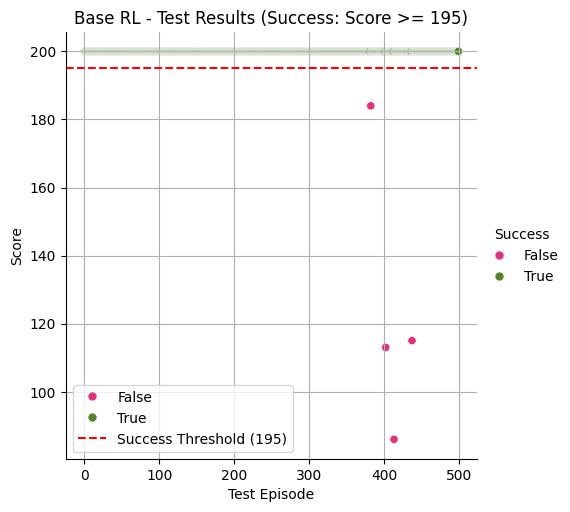

In [8]:
plot_test_results_base_rl(method="Base RL", total_tests=500)